In [0]:
import torch

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.image as mpimg
import pandas as pd
import torch
torch.cuda.is_available()
from torchvision import transforms, datasets
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip -qq '/content/drive/My Drive/catanddog/train_2.zip'


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1xG3dPv3-5G5VDqAOqc0zbLvMX9DcJeRG' # The shareable link

In [6]:
fluff, id = link.split('=')
print (id) # Verify that y

1xG3dPv3-5G5VDqAOqc0zbLvMX9DcJeRG


In [7]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')  
df3 = pd.read_csv('train.csv')
len(df3)

24999

In [8]:
import glob   # loading some train images
img1 = mpimg.imread('train/cat.1.png')
img2 = mpimg.imread('train/cat.1000.png')
len(glob.glob('train/*'))


25000

Text(0.5, 1.0, 'img2')

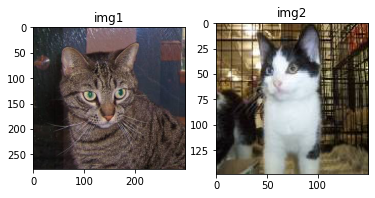

In [9]:

fig = plt.figure()
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(img1)
a.set_title('img1')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(img2)
a.set_title('img2')


In [0]:
from torch.utils.data import Dataset, DataLoader
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torchvision import transforms, utils
class CatandDog(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.labels= pd.read_csv(csv_file)
       
      
        
  def __len__(self):
      return len(self.labels)

  def __getitem__(self, idx):
      
      image_name = os.path.join(self.root_dir,
                              self.labels.iloc[idx, 0])
      #print(image_name)

      image = cv2.imread(image_name)

      #print(image)
      
      # if image has an alpha color channel, get rid of it
#         if(image.shape[2] == 4):
#             image = image[:,:,0:3]
      
      label= self.labels.iloc[idx, 1]
  
      #self.sample = ['image', 'labels']
      if label==0:
          label_=np.array([1,0],dtype="f")
      else:
          label_=np.array([0,1],dtype="f")
      sample = {'image': image, 'labels': label_}
      

      #sample = {'image': image, 'labels': label}
      if self.transform:
          sample = self.transform(sample)

      return sample


# tranforms



In [11]:

device

device(type='cuda', index=0)

In [12]:
#Constructing the dataset
cat_dog_dataset = CatandDog(csv_file='train.csv',
                                      root_dir='train')
train_set, val_set = torch.utils.data.random_split(cat_dog_dataset, [20000, 4999])



# print some stats about the dataset
print('Length of train dataset: ', len(train_set))
sample=type(train_set[1]['image'])


Length of train dataset:  20000


In [13]:
!ls

adc.json  drive  sample_data  train  train.csv


#### Visualizing some images from dataset

0 (375, 499, 3) [0. 1.]
1 (299, 300, 3) [1. 0.]
2 (330, 499, 3) [1. 0.]
3 (253, 186, 3) [1. 0.]
4 (374, 500, 3) [1. 0.]
5 (499, 449, 3) [1. 0.]
6 (299, 207, 3) [0. 1.]
7 (418, 499, 3) [1. 0.]
8 (500, 456, 3) [0. 1.]
9 (342, 499, 3) [0. 1.]


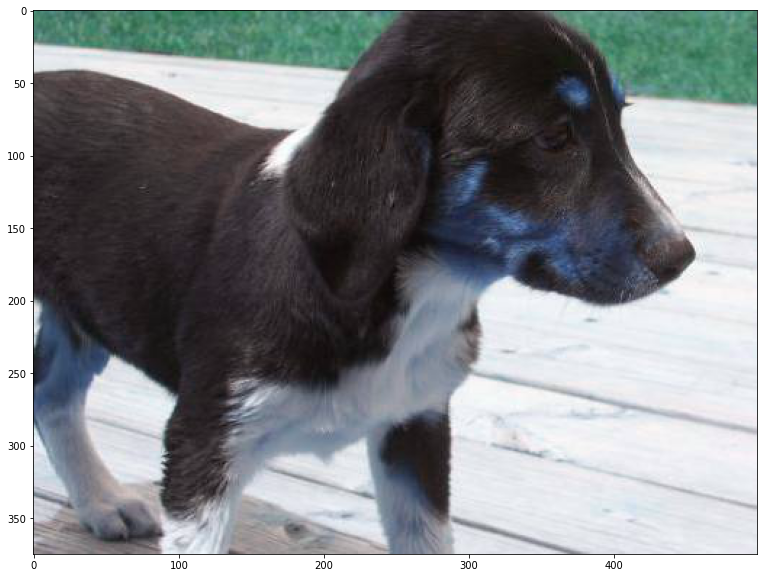

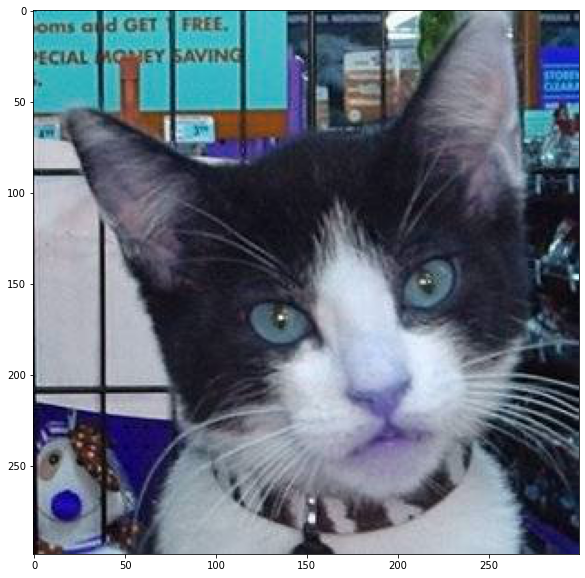

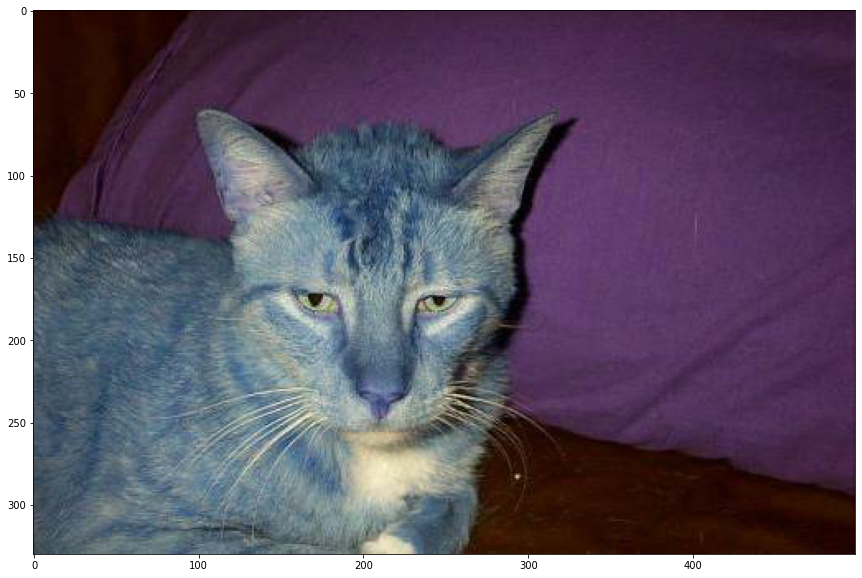

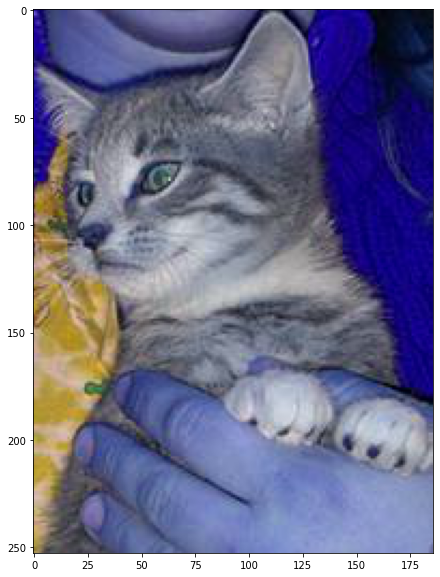

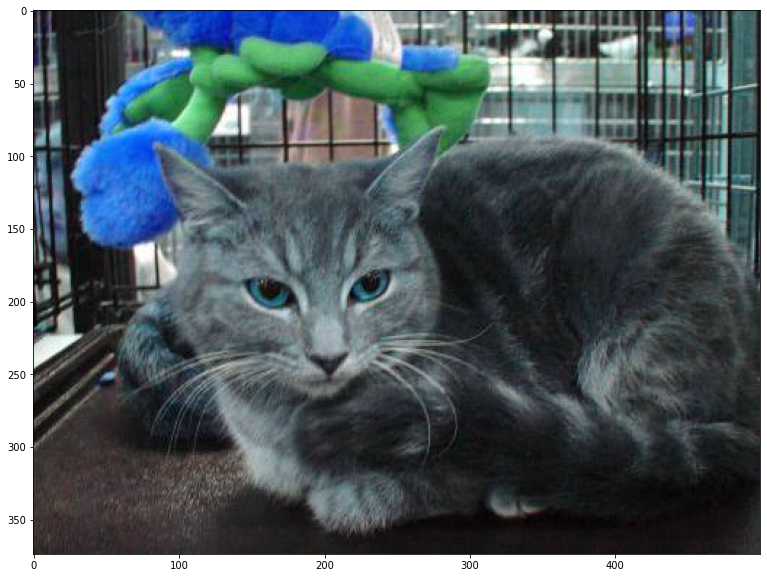

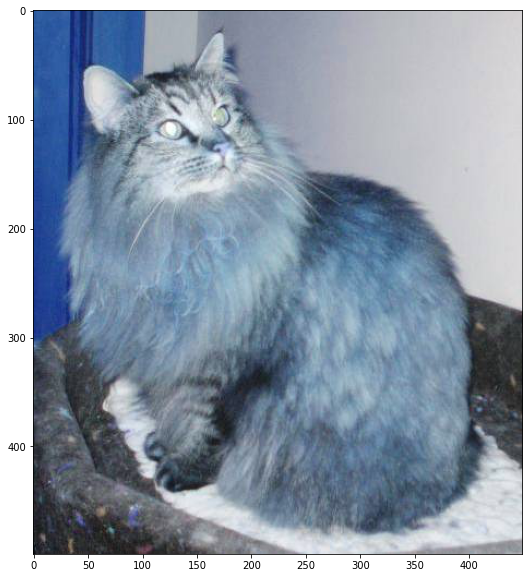

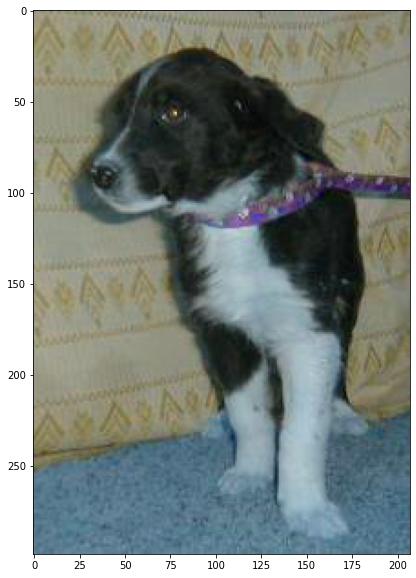

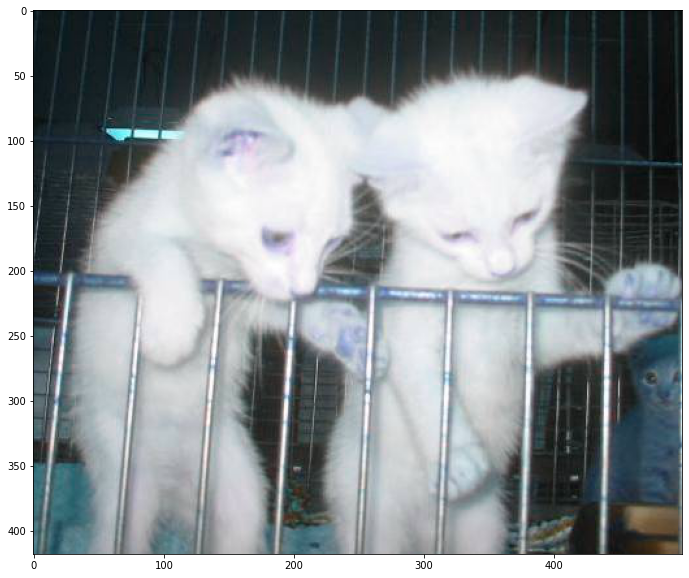

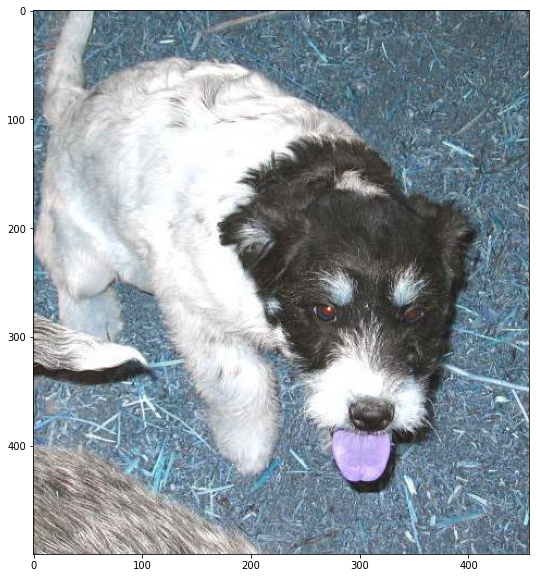

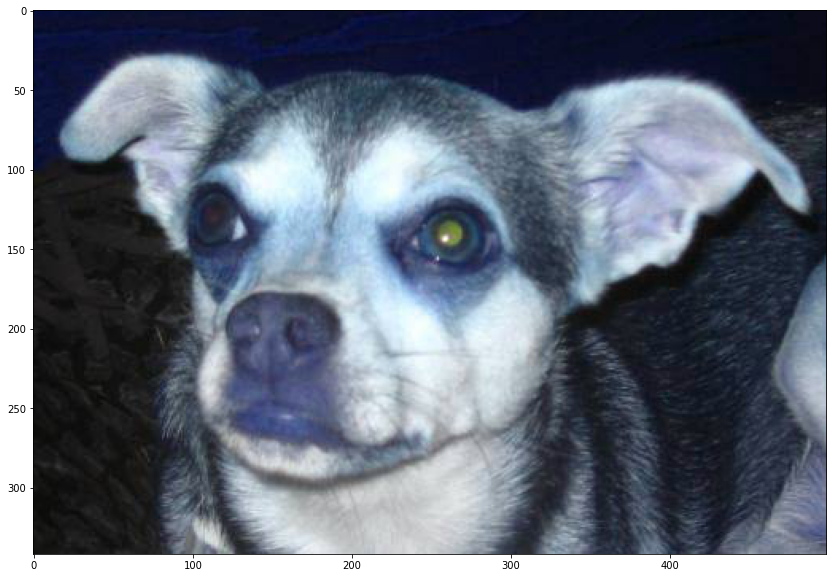

In [14]:

for i in range(10):

  # define the size of images
  fig = plt.figure(figsize=(20,10))

  # randomly select a sample
  rand_i = np.random.randint(0, len(train_set))
  sample = train_set[rand_i]

  # print the shape of the image and keypoints
  print(i, sample['image'].shape, sample['labels'])
  plt.imshow(sample['image'])




# Image Preprocessing


<item>\Normalize: to convert a color image to grayscale values with a range of [0,1]
<item>Rescale: to rescale an image to a desired size.
<item>RandomCrop: to crop an image randomly.
<item>ToTensor: to convert numpy images to torch images.
   <p> We  wrote them as callable classes instead of simple functions so that parameters of the transform need not be passed everytime it's called. For this, we just need to implement __call__ method and (if we require parameters to be passed in), the __init__ method. We can then use a transform like this:

tx = Transform(params)
transformed_sample = tx(sample)\<p>
    

In [0]:
import torch
from torchvision import transforms, utils
# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image = sample['image']
        label = sample['labels']
        image_copy = np.copy(image)
        
        # convert image to grayscale
#         image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0


#         print(image_copy.shape)
        return {'image': image_copy, 'labels': label}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']
        label = sample['labels']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):  # to check if the output_size is of int type
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
       

        return {'image': img, 'labels': label} 


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']
        label = sample['labels']
        h, w = image.shape[0:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'labels': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']
        label = sample['labels']
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 'labels':label}

### Testing operations on some samples

(100, 133, 3) [0. 1.]
(50, 50, 3) [0. 1.]
(224, 224, 3) [0. 1.]


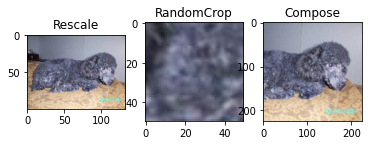

In [16]:

rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transforms to a sample image
test_num = 1000
sample = train_set[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    print(transformed_sample['image'].shape, sample['labels'])
    plt.imshow(sample['image'])
#     plt.tight_layout()
    ax.set_title(type(tx).__name__)
    plt.imshow(transformed_sample['image'])#

plt.show()


In [0]:
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = CatandDog(csv_file='train.csv',
                                      root_dir='train',transform=data_transform)

train_set, val_set = torch.utils.data.random_split(transformed_dataset, [20000, 4999]) # splitting training data into training, test, cross validation


In [18]:
# print some stats about the transformed data
print('Number of images: ', len(train_set))
print('Number of images: ', len(val_set))
#


Number of images:  20000
Number of images:  4999


In [0]:
#Visualizing images from transformed dataset

In [20]:
for x in range(5):
    sample = train_set[x]
    print(sample['image'].size(), sample['labels'])
   

torch.Size([3, 224, 224]) [0. 1.]
torch.Size([3, 224, 224]) [1. 0.]
torch.Size([3, 224, 224]) [1. 0.]
torch.Size([3, 224, 224]) [0. 1.]
torch.Size([3, 224, 224]) [0. 1.]


# Model Architecture

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as I



In [0]:


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
     

   

     ## 1. This network takes in a square (same width and height), grayscale image as input
        
  
        # Covolutional Layers
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 5)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3)
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 2)
        self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 2)
        self.conv6 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 2)
        self.conv7 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 2)
        self.conv8 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 2)
        self.conv9 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 2)
        self.conv10 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 2)
        self.conv11 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 2)
        self.conv12 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 2)
        self.conv13 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 2)



        # Maxpooling Layer
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features = 8192, out_features = 4096)
        self.fc2 = nn.Linear(in_features = 4096,    out_features = 4096)
        self.fc3 = nn.Linear(in_features = 4096,    out_features = 2) 
        # the output 2 - 2 classes
        # Dropouts
        self.drop = nn.Dropout(p = 0.5)

        #Batch normalization
        self.bn1 = nn.BatchNorm1d(4096)  
        self.bn2 = nn.BatchNorm1d(2)      



        


    def forward(self, x):

        # First - Convolution + Activation + Pooling + Dropout
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        #print("First size: ", x.shape)

        # Second - Convolution + Activation + Convolution+ Activation+ Pooling 
        x = self.conv4(F.relu(self.conv3(x)))
        x = self.pool(F.relu(x))
        #print("Second size: ", x.shape)

        # Third - Convolution + Activation + Convolution+ Activation+ Pooling 
        x = self.conv7(F.relu(self.conv6(F.relu(self.conv5(x)))))
        x= self.pool(F.relu(x))
        #print("Third size: ", x.shape)

        # Forth - Convolution + Activation + Convolution + Activation + Convolution + Activation + Pooling
        x = self.conv10(F.relu(self.conv9(F.relu(self.conv8(x)))))
        x= self.drop(self.pool(F.relu(x)))

        #print("Forth size: ", x.shape)

        # Fifth- Convolution + Activation + Convolution + Activation + Convolution + Activation + Pooling
        x = self.conv13(F.relu(self.conv12(F.relu(self.conv11(x)))))
        x= self.drop(self.pool(F.relu(x)))
        #print("Forth size: ", x.shape)

        # Flattening the layer
        x = x.view(x.size(0), -1)
        #print("Flatten size: ", x.shape)

        # First - Dense + batch normalization+  Activation + Dropout
        x = self.bn1(self.fc1(x))
        x= self.drop(F.relu(x))
        #print("First dense size: ", x.shape)

        # Second - Dense + batch normalization+ Activation + Dropout
        x = self.bn1(self.fc2(x))
        x= self.drop(F.relu(x))
        #print("Second dense size: ", x.shape)

        # Final Dense Layer + batch normalization
        x = self.bn2(self.fc3(x))
        #print("Final dense size: ", x.shape)
        output = F.log_softmax(x, dim=1)

        return output

In [23]:

net = Net().to(device)
print(net)


Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1))
  (conv8): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1))
  (conv10): Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1))
  (conv11): Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1))
  (conv12): Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1))
  (conv13): Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=4096, bias=True)
  (fc2): Linear(in_features=4

In [0]:

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


# testing that you've defined a transform
assert(data_transform is not None), "Define a data_tranform"

In [0]:
batch_size = 32

train_loader = DataLoader(train_set, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)
val_loader = DataLoader(val_set, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=False, 
                          num_workers=4)

torch.utils.data.dataloader.DataLoader

In [0]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
  

In [0]:
def train_net(n_epochs):
    #print("Meow")
    # prepare the net for training
    
    criterion = torch.nn.CrossEntropyLoss()
    
    
    optimizer = optim.Adam(params = net.parameters(), lr = 0.0001)
    net.train()
    lossEpoch, accuracyEpoch = [],[]
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        print(epoch)
        running_loss = 0.0
        correct=0.0
        total=0
        loss_values=[]
        accuracy_values=[]
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            labels = data['labels']
            # print(labels)
            labels=labels.type(torch.long)
            images = images.type(torch.FloatTensor)
            # #transferring into cuda
            images=images.to(device)
            labels=labels.to(device)

            # print(labels)
            # forward pass to get outputs
            output_labels = net(images)
            loss = criterion(output_labels, torch.max(labels, 1)[1])

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()
            running_loss = 0.0
            # print loss statistics
            running_loss += loss.item()
            loss_values.append(running_loss)
            _, predicted = torch.max(output_labels.data, 1)
            total += labels.size(0)
            labels_list = []
            for s in range(0,labels.shape[0]):
              labels_list.append(labels[s][1])
            labels = torch.tensor(labels_list)
            labels=labels.to(device)
            #print(labels)
            correct += (predicted == labels).sum().item()
            accuracy=(100 * correct / total)
            accuracy_values.append(accuracy)
            
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}, '.format(epoch + 1, batch_i+1, running_loss))
                print("Accuracy = {}".format(accuracy)) 
        lossEpoch.append(sum(loss_values))
        accuracyEpoch.append(sum(accuracy_values)/len(accuracy_values))
        # accuracy_values, loss_values = [],[]
                    # print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.3f}".format(epoch+1,num_epochs, loss.data[0], correct/x.shape[0]))

    print(accuracyEpoch)
    print(lossEpoch)
    print('Finished Training')
    plt.figure(1)                # the first figure
    plt.subplot(211)             # the first subplot in the first figure
    plt.plot(np.array(lossEpoch), 'r')
    plt.subplot(212)             # the second subplot in the first figure
    plt.plot(np.array(accuracyEpoch), 'b')



0
Epoch: 1, Batch: 10, Avg. Loss: 0.9285069108009338, 
Accuracy = 50.0
Epoch: 1, Batch: 20, Avg. Loss: 1.1734328269958496, 
Accuracy = 49.84375
Epoch: 1, Batch: 30, Avg. Loss: 0.8783427476882935, 
Accuracy = 49.479166666666664
Epoch: 1, Batch: 40, Avg. Loss: 0.8257483243942261, 
Accuracy = 51.5625
Epoch: 1, Batch: 50, Avg. Loss: 0.8236116766929626, 
Accuracy = 50.875
Epoch: 1, Batch: 60, Avg. Loss: 0.6916192770004272, 
Accuracy = 50.78125
Epoch: 1, Batch: 70, Avg. Loss: 0.9550426006317139, 
Accuracy = 50.267857142857146
Epoch: 1, Batch: 80, Avg. Loss: 0.9071802496910095, 
Accuracy = 49.609375
Epoch: 1, Batch: 90, Avg. Loss: 0.9413606524467468, 
Accuracy = 49.72222222222222
Epoch: 1, Batch: 100, Avg. Loss: 0.9053298830986023, 
Accuracy = 49.53125
Epoch: 1, Batch: 110, Avg. Loss: 0.9084036946296692, 
Accuracy = 49.14772727272727
Epoch: 1, Batch: 120, Avg. Loss: 0.8230218887329102, 
Accuracy = 49.036458333333336
Epoch: 1, Batch: 130, Avg. Loss: 0.8116638660430908, 
Accuracy = 48.942307692

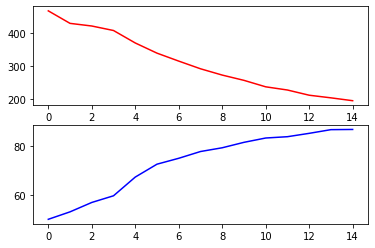

In [74]:
train_net(15)

# Testing model on validation set

In [0]:
def train_net(n_epochs):
    #print("Meow")
    # prepare the net for training
    
    criterion = torch.nn.CrossEntropyLoss()
    
    
    optimizer = optim.Adam(params = net.parameters(), lr = 0.0001)
    net.train()
    lossEpoch, accuracyEpoch = [],[]
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        print(epoch)
        running_loss = 0.0
        correct=0.0
        total=0
        loss_values=[]
        accuracy_values=[]
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(val_loader):
            # get the input images and their corresponding labels
            images = data['image']
            labels = data['labels']
            # print(labels)
            labels=labels.type(torch.long)
            images = images.type(torch.FloatTensor)
            # #transferring into cuda
            images=images.to(device)
            labels=labels.to(device)

            # print(labels)
            # forward pass to get outputs
            output_labels = net(images)
            loss = criterion(output_labels, torch.max(labels, 1)[1])

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()
            running_loss = 0.0
            # print loss statistics
            running_loss += loss.item()
            loss_values.append(running_loss)
            _, predicted = torch.max(output_labels.data, 1)
            total += labels.size(0)
            labels_list = []
            for s in range(0,labels.shape[0]):
              labels_list.append(labels[s][1])
            labels = torch.tensor(labels_list)
            labels=labels.to(device)
            #print(labels)
            correct += (predicted == labels).sum().item()
            accuracy=(100 * correct / total)
            accuracy_values.append(accuracy)
            
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}, '.format(epoch + 1, batch_i+1, running_loss))
                print("Accuracy = {}".format(accuracy)) 
        lossEpoch.append(sum(loss_values))
        accuracyEpoch.append(sum(accuracy_values)/len(accuracy_values))
        # accuracy_values, loss_values = [],[]
                    # print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.3f}".format(epoch+1,num_epochs, loss.data[0], correct/x.shape[0]))

    print(accuracyEpoch)
    print(lossEpoch)
    print('Finished Training')
    plt.figure(1)                # the first figure
    plt.subplot(211)             # the first subplot in the first figure
    plt.plot(np.array(lossEpoch), 'r')
    plt.subplot(212)             # the second subplot in the first figure
    plt.plot(np.array(accuracyEpoch), 'b')



0
Epoch: 1, Batch: 10, Avg. Loss: 0.9809829592704773, 
Accuracy = 52.1875
Epoch: 1, Batch: 20, Avg. Loss: 1.00715172290802, 
Accuracy = 48.75
Epoch: 1, Batch: 30, Avg. Loss: 1.1103581190109253, 
Accuracy = 48.75
Epoch: 1, Batch: 40, Avg. Loss: 0.6523131132125854, 
Accuracy = 48.4375
Epoch: 1, Batch: 50, Avg. Loss: 0.6699434518814087, 
Accuracy = 49.3125
Epoch: 1, Batch: 60, Avg. Loss: 0.8757727742195129, 
Accuracy = 49.010416666666664
Epoch: 1, Batch: 70, Avg. Loss: 0.8008996844291687, 
Accuracy = 49.776785714285715
Epoch: 1, Batch: 80, Avg. Loss: 0.7613690495491028, 
Accuracy = 49.765625
Epoch: 1, Batch: 90, Avg. Loss: 0.8207431435585022, 
Accuracy = 49.513888888888886
Epoch: 1, Batch: 100, Avg. Loss: 0.9651222229003906, 
Accuracy = 49.34375
Epoch: 1, Batch: 110, Avg. Loss: 0.6884633302688599, 
Accuracy = 49.57386363636363
Epoch: 1, Batch: 120, Avg. Loss: 0.8225069046020508, 
Accuracy = 49.270833333333336
Epoch: 1, Batch: 130, Avg. Loss: 0.8895943760871887, 
Accuracy = 49.471153846153

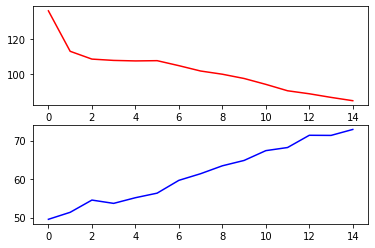

In [29]:
train_net(15)

In [0]:
# path to save model
path = '/content/drive/My Drive/catanddog/model_train_final'

#torch.save(net, path)

In [0]:
torch.save(net.state_dict(), path)

In [58]:
#to load saved model
net.load_state_dict(torch.load(path))

#print(type(model))

<All keys matched successfully>

To test the model - we used 32 images from train set as we did not have ground truth for test images.


In [254]:
labels_list=[]

labels=next(iter(train_loader))['labels'] # ground truth
images=next(iter(train_loader))['image']
for j in range(len(labels)):
      if(labels[j][0] == 1):
        labels_list.append(0)
      else:
        labels_list.append(1)
# print(sample['image'].size(), sample['labels'])

# images=sample['image']+

images = images.type(torch.FloatTensor)
# #transferring into cuda
images=images.to(device)




# Predict classes using images from the test set
outputs = net(images) # predictions of model
pred = output.argmax(dim=1, keepdim=True)

print(labels_list)

    

[0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]


In [0]:
counter=0
for i in range(len(labels_list)):
  if (labels_list[i]==pred[i]):
    counter+=1

  

In [256]:
print(counter)  # predicted 24 correct images out of 32

24


In [0]:
labels=next(iter(train_loader))['labels'] 
images=next(iter(train_loader))['image']